# Assignment 2
### Understanding Uncertainty
### Due 9/12

#### Author: Sam Kunitz-Levy
#### Date: September 10, 2025

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##### Download data

In [3]:
import urllib.request
import os

def download_data(force=False):
    """Download and extract course data from Zenodo."""
    import urllib.request
    import zipfile
    import os
    
    zip_path = 'data.zip'
    data_dir = 'data'
    
    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/16954427/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")
    
    if not os.path.exists(data_dir):
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")
    
    return data_dir

download_data()

'data'

##### Question 1

1. 'State Bottle Retail' is the price at which the bottle is sold, while 'State Bottle Cost' is the price the state pays for a bottle.
- How do you define the most profitable item? Why? Explain your thinking.
- Use `.groupby` calculations to determine the most profitable liquors sold in Iowa.
- Make a plot of the top liquors.

In [4]:
idf = pd.read_csv('./data/iowa.csv')

In [5]:
idf.loc[idf['Item Description'] == 'TEMPLETON RYE 4YR', :].tail(2)

,Invoice/Item Number,Date,Store Number,Store Name,Zip Code,Category Name,Vendor Name,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
154781,INV-52884700159,11/09/2022,2642,HY-VEE WINE AND SPIRITS / PELLA,50219,STRAIGHT RYE WHISKIES,INFINIUM SPIRITS,27175,TEMPLETON RYE 4YR,1000,21.00,31.50,1,31.50
154815,INV-55791600071,02/13/2023,3773,BENZ DISTRIBUTING,52401,STRAIGHT RYE WHISKIES,INFINIUM SPIRITS,27102,TEMPLETON RYE 4YR,750,18.09,27.14,6,162.84


There are two ways to interpret "the most profitable item": on a volume basis and on a percentage basis.  
1. Volume basis: Take the difference of the total revenue and total cost for each item across every invoice. That will show the total profit dollars generated by the item in Iowa during the time period.  
  
2. Percent basis: Take the average (Retail - Cost) / Retail for each item, which gives the highest percentage profitability by item, but does not account for sales volume.  
  
I am choosing Strategy #1, since Strategy #2 has the potential problem of identifying highly profitable but otherwise inconsequential SKUs.  

To run these analyses, I need to group "by item". However, the same Item Description has the potential for multiple "Bottle Volume (ml)" sizes. So I want to base the analysis on Item Number, which will yield the most profitable item for the specific size of that item. This level makes sense to me because different size bottles have different cost inputs.

In [6]:
# Create a total cost column
idf['Order Total Cost'] = idf['Bottles Sold'] * idf['State Bottle Cost']

In [7]:
# Groupby and sum total sales and total cost
grouped = (idf
 .loc[:,['Item Number', 'Sale (Dollars)', 'Order Total Cost']]
 .groupby('Item Number')
 .sum()
 .sort_values(by='Sale (Dollars)', ascending=False)
 .head(20)
)
grouped

,Sale (Dollars),Order Total Cost
Item Number,,
11788,563812.80,374395.20
38178,452920.03,302738.91
43337,361313.16,240740.62
38177,345115.92,230850.31
38176,263633.06,175680.68
26827,259608.91,172659.39
11297,257659.90,171827.14
88296,245889.66,163771.64
11296,240882.01,160812.17


After I tried to merge the Item Description to the Item Number, I realized that there could be multiple Item Descriptions for the same Item Number (e.g. "Jack Daniels Black Label" and "Jack Daniels Black Lbl"). I got ChatGPT to help me identify the most common Item Descriptions and Bottle Volumes, and merge into the table above.

In [8]:
# Find the most common Item descriptions for each Item number
desc_lookup = (
    idf.groupby(['Item Number', 'Item Description'])
    .size()
    .reset_index(name='count')
    .sort_values(['Item Number', 'count'], ascending=[True, False])
    .drop_duplicates('Item Number')
    [['Item Number', 'Item Description']]
)

# Same for bottle volume
vol_lookup = (
    idf.groupby(['Item Number', 'Bottle Volume (ml)'])
    .size()
    .reset_index(name='count')
    .sort_values(['Item Number', 'count'], ascending=[True, False])
    .drop_duplicates('Item Number')
    [['Item Number', 'Bottle Volume (ml)']]
)

# Merge the two, then merge back into grouped result
lookup = desc_lookup.merge(vol_lookup, on='Item Number', how='outer')

result = grouped.merge(lookup, on='Item Number', how='left')
result

,Item Number,Sale (Dollars),Order Total Cost,Item Description,Bottle Volume (ml)
0,11788,563812.80,374395.20,BLACK VELVET,1750
1,38178,452920.03,302738.91,TITOS HANDMADE VODKA,1750
2,43337,361313.16,240740.62,CAPTAIN MORGAN SPICED RUM,1000
3,38177,345115.92,230850.31,TITOS HANDMADE VODKA,1000
4,38176,263633.06,175680.68,TITOS HANDMADE VODKA,750
5,26827,259608.91,172659.39,JACK DANIELS OLD #7 BLACK LBL,1000
6,11297,257659.90,171827.14,CROWN ROYAL CANADIAN WHISKY,1000
7,88296,245889.66,163771.64,PATRON TEQUILA SILVER,750
8,11296,240882.01,160812.17,CROWN ROYAL,750
9,1799,236672.51,158321.03,CAPTAIN MORGAN SPICED BARREL,1750


In [9]:
# Add total profit column
result['Total Profit'] = result['Sale (Dollars)'] - result['Order Total Cost']
result['Item Label'] = result['Item Description'].str.capitalize() + " (" + result['Bottle Volume (ml)'].astype(str) + " ml)"

According to the chart, Black Velvet (1750 ml) generated the most profit dollars in Iowa during this time period, with nearly $200,000 in profit. Rounding out the top 3 are Titos and Captain Morgan, before the other volume sizes for Titos comes into the mix.

<Axes: xlabel='Total Profit', ylabel='Item Label'>

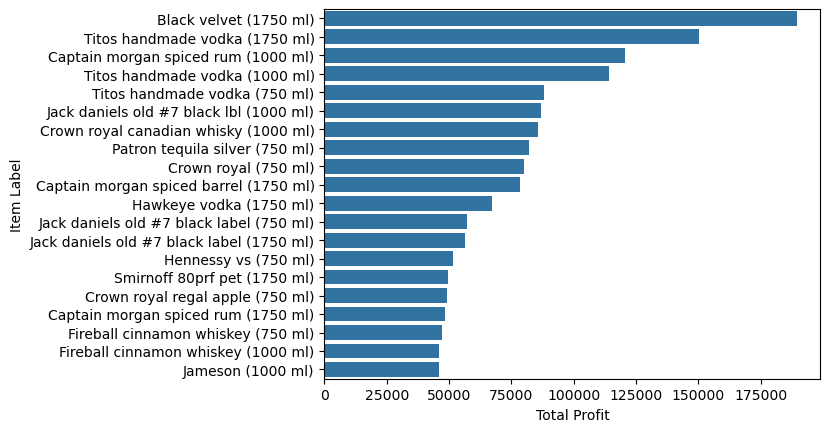

In [10]:
sns.barplot(data=result, x='Total Profit', y='Item Label', orient='h')

2. This question is to further explore broadcasting in NumPy.

- In the first code chunk below, there are two vectors, $x$ and $y$. What happens when you try to subtract them?
- Instead, try `x.reshape(-1,1)-y.reshape(1,-1)`. What do you get?
- Try `x.reshape(1,-1)-y.reshape(-1,1)`. Compare the results to your previous answer.
- Write two double for-loops to replicate the results of the previous two answers. 
- Clearly explain how `x.reshape(1,-1)` and `x.reshape(-1,1)` change $x$

In [11]:
import numpy as np

x = np.array([1,3,5])
y = np.array([2,5])

Python throws an error, saying the operands could not be broadcast together with their different shapes:

In [12]:
y - x # Same result for x - y

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

x.reshape(-1, 1) - y.reshape(1, -1) yielded a 3 x 2 matrix in which the row vector y was subtracted from x, where x was transformed into a 3 x 2 matrix with duplicate columns.

In [ ]:
x.reshape(-1, 1) - y.reshape(1, -1)

array([[-1, -4],
       [ 1, -2],
       [ 3,  0]])

x.reshape(1, -1) - y.reshape(1, -1) yielded a 2 x 3 matrix in which the column vector y was subtracted from a 2 x 3 matrix X that had duplicate rows.

In [ ]:
x.reshape(1, -1) - y.reshape(-1, 1)

array([[-1,  1,  3],
       [-4, -2,  0]])

Double for loops

In [ ]:
three_by_two = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        three_by_two[i, j] = x[i] - y[j]
print(three_by_two)

[[-1. -4.]
 [ 1. -2.]
 [ 3.  0.]]


In [ ]:
two_by_three = np.zeros((len(y), len(x)))
for j in range(len(y)):
    for i in range(len(x)):
        two_by_three[j, i] = x[i] - y[j]
print(two_by_three)

[[-1.  1.  3.]
 [-4. -2.  0.]]


`x.reshape(1,-1)` changes $x$ from a one-dimensional array into a 2-dimensional array with 1 row and 3 columns. Alternatively, `x.reshape(-1,1)` reshapes $x$ into a 2-dimensional array with 3 rows and 1 column. This is essential for broadcasting, since you cannot broadcast across a flat array.

3. The indicator function $\mathbb{I}\{ x \le z \}$ takes the value 0 if $x>z$ and 1 if $x \le z$ is true, or
$$
\mathbb{I}\{x \le z\} = \begin{cases}
0, &x > z \\
1, &x \le z
\end{cases}
$$

- For $x = 3$, plot the indicator function for any $z$
- Explain how $ 1- \mathbb{I}\{ x \le z \} = \mathbb{I}\{ x > z \}$. Drawing a plot might help, or looking at the definition given above.
- The code below generates a random sample for different numbers of observations, $N = 3, 30, 300, 3000 $. Write a function to compute the ECDF curve for each sample, and plot your results.
- Describe in your own words what happens to the ECDF qualitatively as the sample size $N$ increases

In [ ]:
x = 3
grid = np.linspace(-100, 100, 201)
ecdf = 0 * grid.copy()

def indicate(x, grid):
    return x <= grid

indicator = indicate(x, grid)

I only graphed -100 <= z <= 100, but the value of the indicator maintains its values to positive and negatitive infinity.

<Axes: >

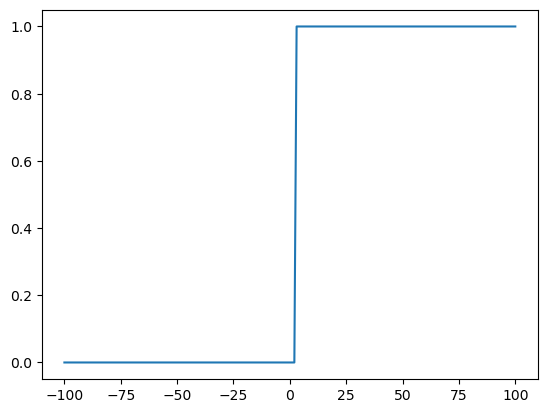

In [ ]:
sns.lineplot(x=grid, y=indicator)

This function $ 1- \mathbb{I}\{ x \le z \}$ sets the indicator to True (1) when previously it was False; and False (0) where previously it was True.  

I graphed the reverse indicator below. The graph shows the indicator function takes on False (0) for grid values greater than or equal to 3, and True (1) values for grid values less than 3. When you compare it with the graph above, it makes sense. If you think of it as "1 minus the above graph", it is 0 when the above graph is 1, and 1 when it is 0. 

<Axes: >

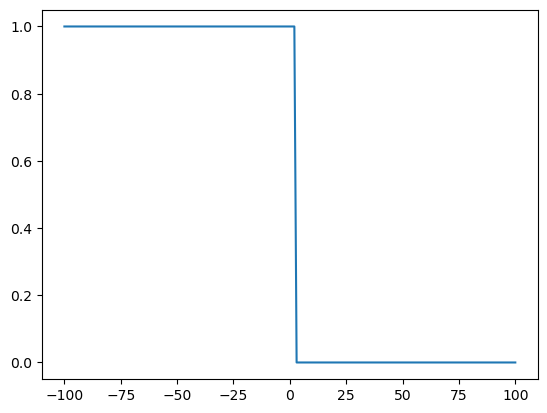

In [ ]:
def reverse_indicate(x, grid):
    return 1 - (x <= grid)

reverse_indicator = reverse_indicate(x, grid)
sns.lineplot(x=grid, y=reverse_indicator)

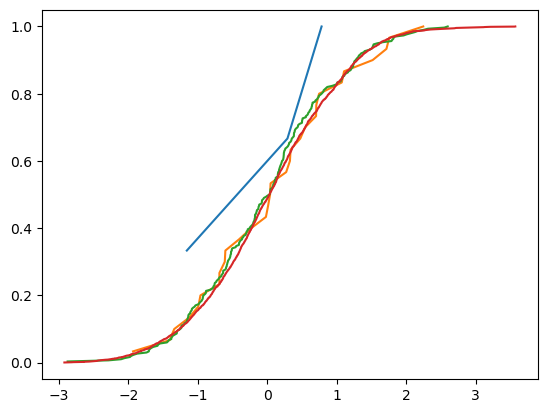

In [ ]:
rng = np.random.default_rng(100)

for N in (3,30,300,3000):
    X = rng.normal(0,1,N)
    # ECDF plot goes here:
    Z = np.sort(np.unique(X))
    compare = X.reshape(-1, 1) <= Z.reshape(1, -1)

    ecdf = np.mean(compare, axis=0)

    sns.lineplot(x=Z, y=ecdf)

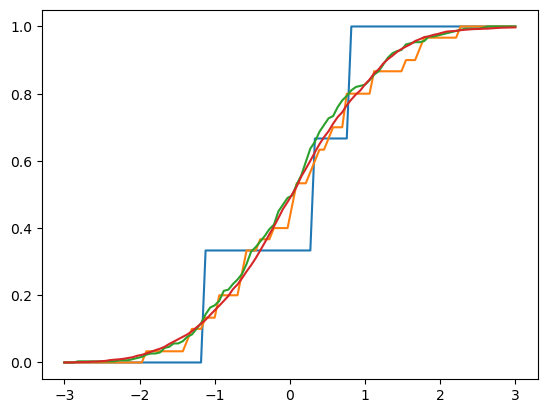

In [ ]:
# I also tried it doing Manual Grid setup
# The starkest difference is in the curve with 3 data points. The grid covers for non-existent data.

rng = np.random.default_rng(100)

for N in (3,30,300,3000):
    X = rng.normal(0,1,N)
    # ECDF plot goes here:
    grid = np.linspace(-3, 3, 100)
    ecdf = 0 * grid.copy()
    for i in range(len(X)):
        F_i = indicate(X[i], grid)
        ecdf += F_i
    ecdf = ecdf / len(X)
    sns.lineplot(x=grid, y=ecdf)

The ECDF curves get smoother as the sample sizes increase. This makes intuitive sense. When n = 3, the curve jumps 33% each time a data point is reached as you iterate along the array. The smoothest curve, the red one in the image, has the most data points. In this situation the curve jumps only an incremental amount each time a new data point is reached as you iterate over the array.

4. A **quantile** generalizes the concept of the median so that instead of 50% of the mass below and 50% above, the $q$-quantile is the value for which $q$ proportion of the data are below that value and $(1-q)$ proportion of the data are above that value. This is a concept of **order**.

- Write a function that computes any quantile without using Numpy's `np.quantile`
- Write a function that computes the **Interquartile Range (IQR)** -- the .25 quantile and the .75 quantile, which brackets 50% of the data -- and the **whiskers**: $\pm 1.5 \times \text{IQR}$ from the edges of the IQR
- Write a function that computes a five-number summary and values for a boxplot: the minimum, the .25 quantile, the median, the .75 quantile, and the maximum, and the whiskers
- Anything outside the whiskers is an **outlier**; write a function that returns a Boolean vector indicating if the observations are outliers.
- For a numeric variable of your choice from one of the datasets, apply your functions from above, and compare your answers with `sns.boxplot` and `df.describe`. 

In [16]:
# Get quantile by using ECDF
def quantile(x, quantile):
    # ECDF
    z = np.sort(x.unique())
    compare = x.to_numpy().reshape(-1, 1) <= z.reshape(1, -1)
    ecdf = np.mean(compare, axis=0)

    # Get the quantile
    distance = (ecdf - quantile) ** 2
    meds = np.where(distance == distance.min())
    return np.mean(z[meds])

# Get IQR
def IQR(x):
    first_quartile = quantile(x, 0.25)
    third_quartile = quantile(x, 0.75)
    interquartile_range = third_quartile - first_quartile
    low_whisker = first_quartile - (interquartile_range * 1.5)
    high_whisker = third_quartile + (interquartile_range * 1.5)
    return interquartile_range, low_whisker, first_quartile, third_quartile, high_whisker

# Get five number summary
def five_number_summary(x):
    interquartile_range, low_whisker, first_quartile, third_quartile, high_whisker = IQR(x)
    minimum = quantile(x, 0)
    median = quantile(x, 0.5)
    maximum = quantile(x, 1)
    print(
        f'Minimum: {minimum}',
        f'0.25 quantile: {first_quartile}',
        f'Median: {median}',
        f'0.75 quantile: {third_quartile}',
        f'Maximum: {maximum}',
        f'Lower whisker: {low_whisker}',
        f'Upper whisker: {high_whisker}',
        sep='\n')
    return minimum, first_quartile, median, third_quartile, maximum, low_whisker, high_whisker

# Get outliers
def outliers(x):
    _, low_whisker, _, _, high_whisker = IQR(x)
    low_outlier = x.to_numpy() < low_whisker
    high_outlier = x.to_numpy() > high_whisker
    return low_outlier + high_outlier

Minimum: 0.0
0.25 quantile: 8.66
Median: 12.99
0.75 quantile: 19.92
Maximum: 3448.26
Lower whisker: -8.23
Upper whisker: 36.81


count    159904.000000
mean         16.480350
std          17.099067
min           0.000000
25%           8.670000
50%          12.990000
75%          19.920000
max        3448.260000
Name: State Bottle Retail, dtype: float64

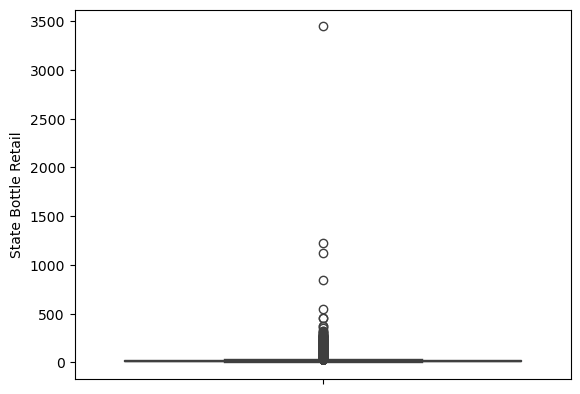

In [17]:
# Analyze retail cost of alcohol sales
quantile(idf['State Bottle Retail'], 0.5)
five_number_summary(idf['State Bottle Retail'])
outliers(idf['State Bottle Retail'])

# Compare with built-in functions
sns.boxplot(idf['State Bottle Retail'])
idf['State Bottle Retail'].describe()

The numbers are identical, except for three points:
- 0.25 quantile differs by 0.01
- Summarize does not have data points for the upper or lower whisker

5. The kernel density estimator captures the concentration of the data around various points, and is defined as
$$
\hat{f}_{N,h}(z) = \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k \left( \frac{x_i - z}{h}\right)
$$
where $h$ is the bandwidth and $k()$ is one of the kernel functions from the class materials (Gaussian, Epanechnikov, uniform, triangular).

- Write a function that takes the bandwidth $h$ as given, and computes and plots $\hat{f}_{N,h}(z)$, for the kernels listed in the slides
- Write a function that computes the plug-in bandwidth
- Use your functions to analyze some numeric variables from a dataset of your choice, using a variety of bandwidths
- Compare bandwidths that are greater or less than the plug-in value with the results for the plug-in value. When does the KDE appear to be overfitting? Underfitting?